# 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cv2

In [2]:
# Mounting the file directory
# from google.colab import drive
# drive.mount('/content/drive')

# import os
# os.chdir('/content/drive/MyDrive/Colab Notebooks/computer_vision/Panorama')

In [32]:
grayImg = 'albert-einstein_gray.jpg'
colorImg = 'tulips.jpg'
affineWarped = 'affine-transformed image.jpg'

I_gray = cv2.imread(grayImg, cv2.IMREAD_GRAYSCALE)
I_affineWarped = cv2.imread(affineWarped, cv2.IMREAD_GRAYSCALE)
I_BGR = cv2.imread(colorImg)
I_BGRGray = cv2.imread(colorImg, cv2.IMREAD_GRAYSCALE)

In [4]:

def displayImageInActualSize(I):
  dpi = mpl.rcParams['figure.dpi']
  h,w = I.shape
  figSize = w/float(dpi), h/float(dpi)
  fig = plt.figure(figsize = figSize)
  ax = fig.add_axes([0,0,1,1])
  ax.axis('off')
  ax.imshow(I,cmap='gray')
  plt.show

def f_bilinearInterpolate(r,c,I):
  # Inside the boundary of the image

    # Getting 4 nearest neighbor coordinates
    lc = int(c)
    rc = lc + 1
    wr = c - lc
    wl = rc - c
    tr = int(r)
    br = tr + 1
    wt = br - r
    wb = r-tr

    if tr >= 0 and br<I.shape[0] and lc >= 0 and rc<I.shape[1]:
      # First step get horizontal wweighting
      a = wl*I[tr,lc] + wr*I[tr,rc]
      b = wl*I[br,lc] + wr*I[br,rc]
      # Second vertical weighting
      g = wt*a + wb*b
      return np.uint8(g)
    else:
      return 0

def displayImageInActualSizeColor(I):
  dpi = mpl.rcParams['figure.dpi']
  h,w,z = I.shape
  figSize = w/float(dpi), h/float(dpi)
  fig = plt.figure(figsize = figSize)
  ax = fig.add_axes([0,0,1,1])
  ax.axis('off')
  ax.imshow(I)
  plt.show

def get_scaling_matrix(scale):
  size = len(scale)
  matrix = np.zeros((size,size))
  for i,_ in enumerate(matrix):
    matrix[i][i] = scale[i]
  return matrix

def f_scaleImage(scale,I_gray):
  # Checking S is valid identity matrix

  numRows = I_gray.shape[0]
  numCols = I_gray.shape[1]
  S = get_scaling_matrix(scale)
  I2 = np.zeros((int(scale[0])*numRows, int(scale[1])*numCols),dtype='uint8')

  # Inverse scaling
  Tinv = np.linalg.inv(S)

  for new_i in range(I2.shape[0]):
    for new_j in range(I2.shape[1]):
      p_dash = np.array([new_i,new_j])
      p = Tinv.dot(p_dash)
      #p = np.int16(np.round(p))
      i,j = p[0],p[1]
      if i < 0 or i>=numRows or j<0 or j>=numCols:
        pass
      else:
        g = f_bilinearInterpolate(i,j,I_gray)
        I2[new_i,new_j] = g

  return I2


In [5]:
def f_getExtents(T,rMax,cMax):
  Cords = np.array([[0,0],[0,cMax-1],[rMax-1,0],[rMax-1,cMax-1]])
  A_dash = T.dot(Cords.T)
  mins = A_dash.min(axis=1)
  maxs = A_dash.max(axis=1)
  minR = np.int64(np.floor(mins[0]))
  minC = np.int64(np.floor(mins[1]))
  maxR = np.int64(np.ceil(maxs[0]))
  maxC = np.int64(np.ceil(maxs[1]))
  H, W = maxR-minR+1, maxC-minC + 1
  return minR,minC,maxR,maxC,H,W

def f_transform(T,I_gray):
  rMax,cMax = I_gray.shape[0], I_gray.shape[1]
  minR,minC,maxR,maxC,H,W = f_getExtents(T,rMax,cMax)
  numRows = I_gray.shape[0]
  numCols = I_gray.shape[1]
  I2 = np.zeros((H,W),dtype = 'uint8')
  Tinv = np.linalg.inv(T)
  for new_i in range(minR,maxR):
    for new_j in range(minC,maxC):
      P_dash = np.array([new_i,new_j])
      P = Tinv.dot(P_dash)
      i,j = P[0], P[1]
      if i < 0 or i>=numRows or j<0 or j>=numCols:
        pass
      else:
        g = f_bilinearInterpolate(i,j,I_gray)
        I2[new_i-minR,new_j-minC] = g
  return I2

def f_getExtentsAffine(T,rMax,cMax):
  Cords = np.array([[0,0,1],[0,cMax-1,1],[rMax-1,0,1],[rMax-1,cMax-1,1]])
  A_dash = T.dot(Cords.T)
  mins = A_dash.min(axis=1)
  maxs = A_dash.max(axis=1)
  minR = np.int64(np.floor(mins[0]))
  minC = np.int64(np.floor(mins[1]))
  maxR = np.int64(np.ceil(maxs[0]))
  maxC = np.int64(np.ceil(maxs[1]))
  H, W = maxR-minR+1, maxC-minC + 1
  return minR,minC,maxR,maxC,H,W

def f_transformAffine(T,I_gray):
  rMax,cMax = I_gray.shape[0], I_gray.shape[1]
  numRows = I_gray.shape[0]
  numCols = I_gray.shape[1]
  minR,minC,maxR,maxC,H,W = f_getExtentsAffine(T,rMax,cMax)
  I2 = np.zeros((H,W),dtype = 'uint8')
  Tinv = np.linalg.inv(T)
  for new_i in range(minR,maxR):
    for new_j in range(minC,maxC):
      P_dash = np.array([new_i,new_j,1])
      P = Tinv.dot(P_dash)
      i,j = P[0], P[1]
      if i < 0 or i>=numRows or j<0 or j>=numCols:
        pass
      else:
        g = f_bilinearInterpolate(i,j,I_gray)
        I2[new_i-minR,new_j-minC] = g
  return I2

def f_getExtentsProjective(T,rMax,cMax):
  Cords = np.array([[0,0,1],[0,cMax-1,1],[rMax-1,0,1],[rMax-1,cMax-1,1]])
  A_dash = T.dot(Cords.T)
  A_dash = A_dash/A_dash[2,:]
  mins = A_dash.min(axis=1)
  maxs = A_dash.max(axis=1)
  minR = np.int64(np.floor(mins[0]))
  minC = np.int64(np.floor(mins[1]))
  maxR = np.int64(np.ceil(maxs[0]))
  maxC = np.int64(np.ceil(maxs[1]))
  H, W = maxR-minR+1, maxC-minC + 1
  return minR,minC,maxR,maxC,H,W

# Most generalized form
def f_transformProjective(T,I_gray):
  rMax,cMax = I_gray.shape[0], I_gray.shape[1]
  numRows = I_gray.shape[0]
  numCols = I_gray.shape[1]
  minR,minC,maxR,maxC,H,W = f_getExtentsProjective(T,rMax,cMax)
  I2 = np.zeros((H,W),dtype = 'uint8')
  Tinv = np.linalg.inv(T)
  for new_i in range(minR,maxR):
    for new_j in range(minC,maxC):
      P_dash = np.array([new_i,new_j,1])
      P = Tinv.dot(P_dash)
      P = P/P[2]
      i,j = P[0], P[1]
      
      if i < 0 or i>=numRows or j<0 or j>=numCols:
        pass
      else:
        g = f_bilinearInterpolate(i,j,I_gray)
        I2[new_i-minR,new_j-minC] = g
  return I2

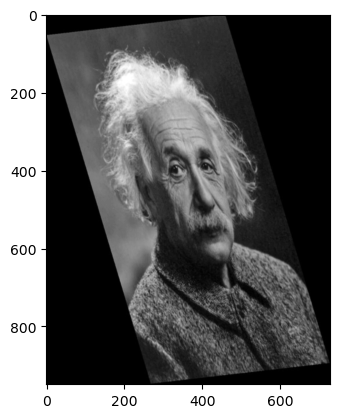

In [6]:
plt.imshow(I_affineWarped, cmap='gray')

In [7]:
def f_getPoints(I,numPts):
  %matplotlib
  fig,ax = plt.subplots(1,figsize=(15,30))
  plt.imshow(I,cmap='gray')
  pts = np.round(np.array(plt.ginput(n=numPts)))
  # First column is column coordinates, and second is row
  # Want to flip this
  pts = pts[:,[1,0]].T
  plt.close()
  return pts

In [8]:
pts = f_getPoints(I_gray,4)

Using matplotlib backend: <object object at 0x000002AB2908B5C0>


In [9]:
pts

array([[402., 402., 562., 565.],
       [321., 496., 358., 467.]])

In [10]:
P = f_getPoints(I_gray,3)

Using matplotlib backend: QtAgg


In [11]:
P_dash = f_getPoints(I_affineWarped,3)

Using matplotlib backend: QtAgg


In [12]:
P = np.vstack((P,np.ones((1,3))))
P_dash = np.vstack((P_dash,np.ones((1,3))))

In [13]:
P_dash

array([[405., 397., 560.],
       [313., 424., 381.],
       [  1.,   1.,   1.]])

In [14]:
np.linalg.det(P)

-28258.000000000025

In [15]:
# Found the transformation martix
A = P_dash.dot(np.linalg.inv(P))

In [16]:
I2 = f_transformProjective(A, I_gray)

In [ ]:
plt.figure(1)
plt.subplot(121)
plt.imshow(I_gray,cmap='gray')
plt.subplot(122)
plt.imshow(I2,cmap='gray')
plt.show()

# Using More than 3 Points

In [18]:
P_dash = f_getPoints(I_affineWarped,5)

Using matplotlib backend: QtAgg


In [19]:
P = f_getPoints(I_gray,5)

Using matplotlib backend: QtAgg


In [20]:
P = np.vstack((P,np.ones((1,5))))
P_dash = np.vstack((P_dash,np.ones((1,5))))

In [21]:
A = P_dash.dot(P.T).dot(np.linalg.inv(P.dot(P.T)))

# 

In [22]:
A

array([[ 9.69445583e-01, -8.19818878e-02,  4.52073576e+01],
       [ 3.51432351e-01,  6.50573555e-01, -3.69114778e+01],
       [ 0.00000000e+00, -5.20417043e-18,  1.00000000e+00]])

In [23]:
I2 = f_transformProjective(A, I_gray)

In [27]:
plt.figure(1)
plt.subplot(121)
plt.imshow(I_affineWarped,cmap='gray')
plt.subplot(122)
plt.imshow(I2,cmap='gray')
plt.show()

#Quiz

In [33]:
I2 = f_transformProjective(A, I_BGRGray)
plt.imshow(I2)

# Projective Homography Estimation

In [39]:
a = 0
ca = np.cos(np.deg2rad(a))
sa = np.sin(np.deg2rad(a))
R = np.array([[ca,-sa,0],[sa,ca,0], [0,0,1]])
# Rotate about point (300,400)
T = np.array([[1,0,-2],[0,1,0],[0,0,1]])
Rf = np.array([[1,0,0],[0,-1,0],[0,0,1]])
A = np.linalg.inv(T).dot(np.linalg.inv(R)).dot(Rf).dot(R).dot(T)
H = A
H[2,:] = np.array([0.0001,.001,1])

In [40]:
I_projectiveWarped = f_transformProjective(H,I_gray)

In [41]:
P = f_getPoints(I_gray,3)

Using matplotlib backend: QtAgg


In [42]:
P_dash = f_getPoints(I_projectiveWarped,3)

Using matplotlib backend: QtAgg


In [43]:
P = np.vstack((P,np.ones((1,3))))
P_dash = np.vstack((P_dash,np.ones((1,3))))

In [45]:
H = P_dash.dot(np.linalg.inv(P))

In [46]:
I2 = f_transformProjective(H, I_gray)

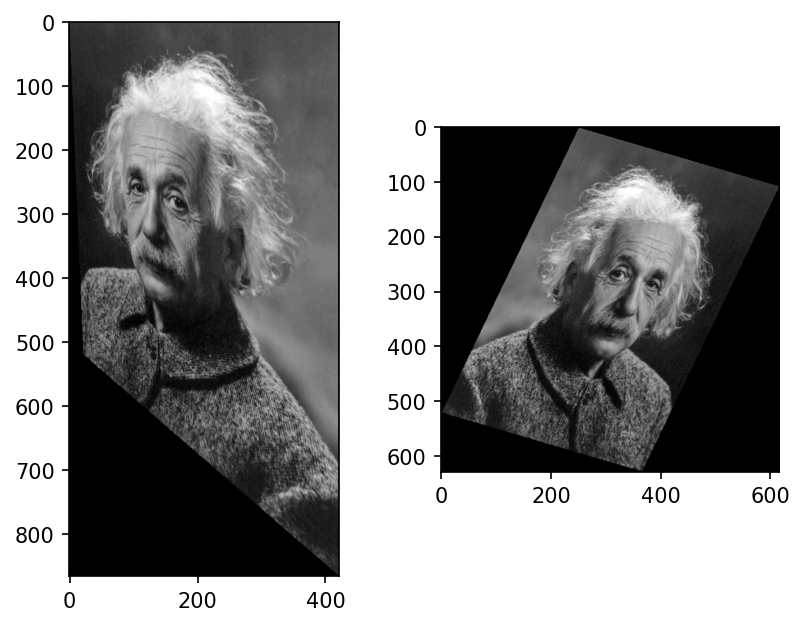

In [49]:
%matplotlib inline
plt.figure(1)
plt.subplot(121)
plt.imshow(I_projectiveWarped,cmap='gray')
plt.subplot(122)
plt.imshow(I2,cmap='gray')
plt.show()
# Transformation bug!

In [50]:
# Handles noisy cases unlike scipi algorithm
def f_computeRightNullSpace(A):
    B = A.T.dot(A)
    w,v = np.linalg.eig(B)
    idx = np.argmin(w)
    nullVector = v[:,idx]
    return nullVector

In [51]:
A = np.random.rand(3,4)
nv = f_computeRightNullSpace(A)

In [52]:
nv

array([-0.39861222, -0.51246657,  0.75222178,  0.11246648])

In [53]:
# Verifying the null vector was correct!
A.dot(nv)

array([-1.11022302e-16,  0.00000000e+00, -1.11022302e-16])

In [77]:
P = f_getPoints(I_gray,6)

Using matplotlib backend: QtAgg


In [78]:
P_dash = f_getPoints(I_projectiveWarped,6)

Using matplotlib backend: QtAgg


In [79]:
P = np.vstack((P,np.ones((1,6))))
P_dash = np.vstack((P_dash,np.ones((1,6))))

In [80]:
A = np.zeros((12,9))
A[::2,:3] = -P.T
A[1::2,3:6] = -P.T
A[::2,6:] = P.dot(np.diag(P_dash[0,:])).T
A[1::2,6:] = P.dot(np.diag(P_dash[1,:])).T

h = f_computeRightNullSpace(A)

In [81]:
H = np.reshape(h,(3,3))

In [59]:
H

array([[ 4.09107463e-05, -1.82323243e-03,  9.40083601e-01],
       [-4.13192042e-05, -5.89735786e-04,  3.40913339e-01],
       [-1.16432809e-06, -7.06647948e-06,  4.15258248e-03]])

In [82]:
I2 = f_transformProjective(H, I_gray)

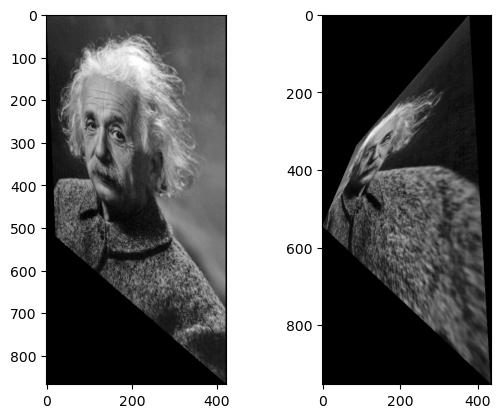

In [83]:
%matplotlib inline
plt.figure(1)
plt.subplot(121)
plt.imshow(I_projectiveWarped,cmap='gray')
plt.subplot(122)
plt.imshow(I2,cmap='gray')
plt.show()

#Quiz

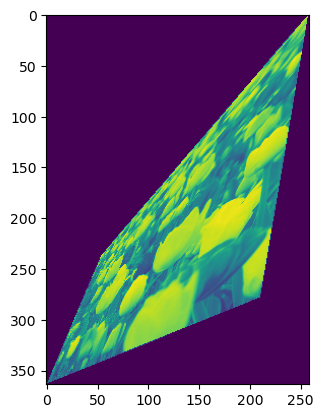

In [84]:
I2 = f_transformProjective(H, I_BGRGray)
plt.imshow(I2)

#Panoramic Stitching with OpenCV

In [90]:
im1 = cv2.imread('mtn1.png')
im2 = cv2.imread('mtn2.png')
im3 = cv2.imread('mtn3.png')

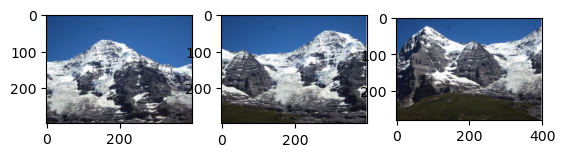

In [94]:
plt.subplot(131)
plt.imshow(im1[:,:,::-1])
plt.subplot(132)
plt.imshow(im2[:,:,::-1])
plt.subplot(133)
plt.imshow(im3[:,:,::-1])
plt.show()

In [95]:
imgs = []
imgs.append(im3)
imgs.append(im2)
imgs.append(im1)

In [96]:
M = cv2.Stitcher.create(cv2.Stitcher_PANORAMA)
status, pano = M.stitch(imgs)

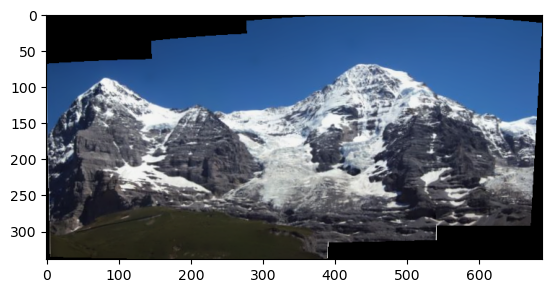

In [97]:
plt.imshow(pano[:,:,::-1])